Загрузка библиотек

In [ ]:
pip install transformers datasets evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.wh

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

Загрузка датасета

In [ ]:
dataset = load_dataset('rotten_tomatoes', trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Обучение

In [ ]:
def get_tokenizer(examples):
    return tokenizer(examples['text'], truncation=True)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')
tokenized_dataset = dataset.map(get_tokenizer, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
accuracy = evaluate.load('accuracy')

In [ ]:
id_key = {0: 'neg', 1: 'pos'}
label_key = {'neg': 0, 'pos': 1}

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('distilbert/distilbert-base-uncased', num_labels=2, id2label=id_key, label2id=label_key)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def get_acc(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(output_dir='results', learning_rate=1e-4, per_device_train_batch_size=32, per_device_eval_batch_size=32, num_train_epochs=50, weight_decay=0.01, eval_strategy='epoch', save_strategy='epoch', save_total_limit=4, load_best_model_at_end=True)

In [ ]:
trainer = Trainer(model=model, args=training_args, train_dataset=tokenized_dataset["train"], eval_dataset=tokenized_dataset["validation"], tokenizer=tokenizer, data_collator=data_collator, compute_metrics=get_acc, callbacks=[EarlyStoppingCallback(early_stopping_patience=4)])

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.393376,0.831144
2,0.330100,0.436195,0.846154
3,0.330100,0.554013,0.818011
4,0.108900,0.826042,0.831144
5,0.108900,0.759545,0.836773


TrainOutput(global_step=1335, training_loss=0.1802414183313034, metrics={'train_runtime': 233.7069, 'train_samples_per_second': 1824.936, 'train_steps_per_second': 57.123, 'total_flos': 580344848019696.0, 'train_loss': 0.1802414183313034, 'epoch': 5.0})

In [ ]:
targets = dataset['test']['label']

In [ ]:
pipe = pipeline('text-classification', model='results/checkpoint-1335')
predictions = []

for out in pipe(KeyDataset(dataset['test'], 'text')):
    predictions.append(label_key[out['label']])

In [ ]:
print(classification_report(targets, predictions))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       533
           1       0.84      0.80      0.82       533

    accuracy                           0.83      1066
   macro avg       0.83      0.83      0.83      1066
weighted avg       0.83      0.83      0.83      1066



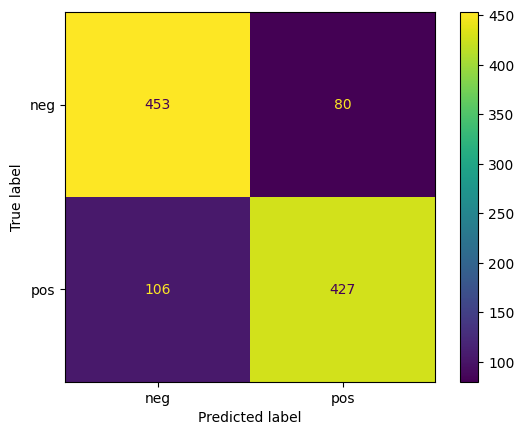

In [ ]:
cm = confusion_matrix(targets, predictions)
ConfusionMatrixDisplay(cm, display_labels=np.array(list(label_key.keys()))).plot()